## Application of the Bures method for chemical kinetics
The Bures method is a graphical method **[references]** for the determination of reaction orders, employing only concentration data without the need of computing reaction rates. It relies on the overlap of different concentration curves, and thus it cannot be fully parametrized or automated. Nevertheless, it offers an easy way to determine reaction orders, and it can be easily implemented in Python.

In this project, we will consider two "variants" of the method. The first considers only the order in *catalyst*, which is easier to implement due to the catalyst concentration being constant across the kinetics. The second (also known as the VTNA - Variable Time Normalization Analysis) method is more general, and can be applied to any of the reactants, but it is a bit more complex.

### 1. Order in catalyst

There must be at least *two* data series with different initial catalyst loadings.

*Graphical* method: plot the concentrations at different catalyst loadings against the Z variable $Z = t \cdot [cat]^{r}$. The value of **r** for which all the curves fully overlap is the order in catalyst for the reaction.

Key steps:
1. Read information: CSV file.
2. Format and clean data: get catalyst concentration values for each column.
3. Plot the concentration vs. time profiles.
4. Try a value for **r** and plot concentration vs $t \cdot [cat]^{r}$ profiles.
5. Attempt to locate ideal **r** value.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
# 1. Read information: CSV file.
data = pd.read_csv("datasets/m1_fig2a_simple_michaelis.dat",sep=" ")
display(data)

,time,0.05,0.02,0.01,0.005
0,0.00,1.013,1.003,1.015,1.001
1,0.03,0.847,0.929,0.981,0.979
2,0.06,0.681,0.866,0.922,0.968
3,0.08,0.586,0.809,0.895,0.928
4,0.11,0.476,0.752,0.863,0.935
...,...,...,...,...,...
246,6.83,0.016,0.001,0.007,-0.011
247,6.86,0.008,-0.007,0.020,-0.004
248,6.89,0.005,0.009,-0.003,0.014
249,6.92,0.000,0.003,0.011,-0.006


In [5]:
# 2. Format and clean data: get catalyst concentration values for each column.
c_vals = [float(item) for item in data.columns[1:]]

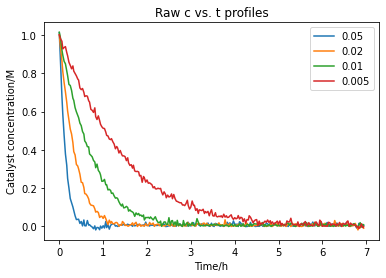

In [6]:
# 3. Plot the concentration vs. time profiles.
fig = plt.figure()
ax = fig.add_subplot()
for jj,cat in enumerate(c_vals):
    ax.plot(data.loc[:,"time"],data.loc[:,str(cat)],label=cat)
ax.set_title("Raw c vs. t profiles")
ax.set_xlabel("Time/h")
ax.set_ylabel("Catalyst concentration/M")
ax.legend()

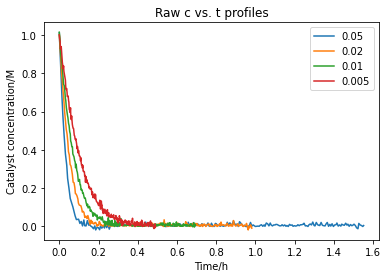

In [7]:
#4. Try a value for **r** and plot concentration vs $t \cdot [cat]^{r}$ profiles.
fig = plt.figure()
ax = fig.add_subplot()

r = 0.5

for jj,cat in enumerate(c_vals):
    time = data["time"]
    ax.set_title("r = %.2f" % r)
    x = time*(cat)**r
    ax.plot(x,data.loc[:,str(cat)],label=cat)
ax.set_title("Raw c vs. t profiles")
ax.set_xlabel("Time/h")
ax.set_ylabel("Catalyst concentration/M")
ax.legend()

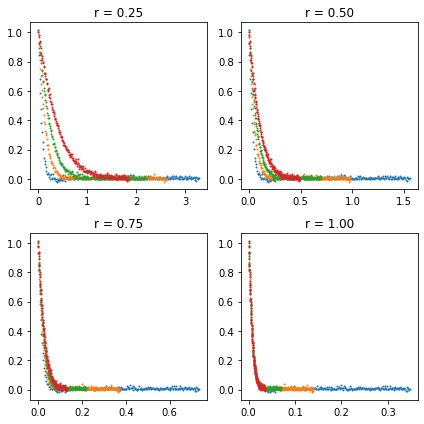

In [8]:
# 5. Attempt to locate ideal **r** value.

r_test = [0.25,0.50,0.75,1.00]

fig,axes = plt.subplots(2,2,figsize=(6,6))
ax = axes.flatten()
for ii,r in enumerate(r_test):
    time = data["time"]
    ax[ii].set_title("r = %.2f" % r)
    for jj,cat in enumerate(c_vals):
        x = time*(cat)**r
        ax[ii].scatter(x,data.iloc[:,jj+1],s=1)

plt.tight_layout()

### 2. Application of the more general VTNA 
Not as straightforward as the previous one, but appliable to any reactant in the process. For each reactant whose order is to be determined, we need at least *two* data series where only the concentration of that reactant X varies, with all other variables being constant.

*Graphical* method: plot the concentrations at different initial loadings against an estimation of the time integral of the concentration of X to the power of *r*. The formula for this is:

$Z = \int_{0̣}^{n} [X]^{r} dt = \sum_{i=1}^{n} \left(\frac{[A]_{i} + [A]_{i-1}}{2}\right) (t_{i} - t_{i-1})$

When plotting Z against any concentration in the dataset, the value of **r** for which all the curves fully overlap is the order in X for the reaction.

Key steps:
1. Read information: multiple CSV files, with datasets and initial info.
2. Format and clean data: get the information sets for each molecules so that every parameter is constant except for the concentration of the target species.
3. Plot the concentration vs. time profiles.
4. Try a value for **r<sub>X</sub>** and plot concentration vs **Z** profiles.
5. Attempt to locate ideal **r** value.

#### Data manipulation
The **Z** term requires a few important data transformations from the raw concentration array:
1. From time, we need the *intervals* $\Delta{}t = t_{i} - t_{i-1}$.
2. For the target concentrations, we need *rolling averages* that take $c_i$ and $c_{i-1}$, to compute $0.5 (c_i + c_{i-1})$.
3. Then, we compute the product term $\Delta{}t\cdot[X]_{avg}^{r}$.
4. Finally, the *cumulative sum* of the product terms produces the final **Z**.



In [11]:
general_info = pd.read_csv("datasets/vtna_ex1_init_vals.dat",sep=" ",index_col=0)
# Read all individual files
dflist = []
for expidx in general_info.index:
    df = pd.read_csv("datasets/vtna_ex1_%d.dat" % expidx,sep=" ")
    df.loc[:,"exp"] = expidx
    dflist.append(df)

,A0,B0,cat
Exp,,,
1,1.0,0.6,0.01
2,0.6,0.6,0.01
3,1.0,0.8,0.01
4,1.0,0.6,0.03


In [23]:
general = pd.read_csv("vtna_ex1_init_vals.dat",sep=" ",index_col=0)
experiments = pd.read_csv("vtna_ex1_all.dat",sep=" ",index_col=0)

In [12]:
# Check which combinations have to be considered: pairs of experiments where everything is constant
# except for one variable
display(general_info)

# Pairs: 1-2 (for A), 1-3 (for B) and 1-4 (for cat)

,A0,B0,cat
Exp,,,
1,1.0,0.6,0.01
2,0.6,0.6,0.01
3,1.0,0.8,0.01
4,1.0,0.6,0.03


Text(0, 0.5, '[A]/M')

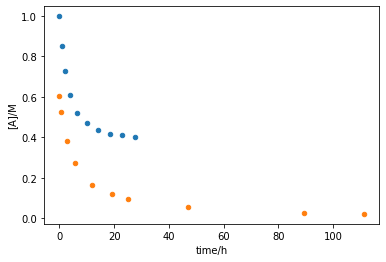

In [13]:
### Species A: plot the corresponding concentration curves first
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(dflist[0]["time"],dflist[0]["A"],s=20)
ax.scatter(dflist[1]["time"],dflist[1]["A"],s=20)

ax.set_xlabel("time/h")
ax.set_ylabel("[A]/M")

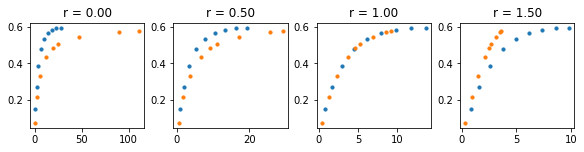

In [16]:
### Testing r values

ra_test = [0,0.5,1,1.5]
dfa1 = dflist[0]
dfa2 = dflist[1]

fig,axes = plt.subplots(1,4,figsize=(8,2),constrained_layout=True)
ax = axes.flatten()


# We need time increments and concentration averages on intervals
for ii,ra in enumerate(ra_test):
    ax[ii].set_title("r = %.2f" % ra)
    # differences
    dt1 = dfa1["time"].diff().dropna()
    dt2 = dfa2["time"].diff().dropna()
    
    # averages
    avg1 = dfa1.rolling(window=2).mean().dropna()
    avg2 = dfa2.rolling(window=2).mean().dropna()
    x1 = dt1*(avg1["A"])**ra
    x2 = dt2*(avg2["A"])**ra
    # and the term is the cumulative sum
    ax[ii].scatter(x1.cumsum(),dfa1["P"].iloc[1:],s=10)
    ax[ii].scatter(x2.cumsum(),dfa2["P"].iloc[1:],s=10)



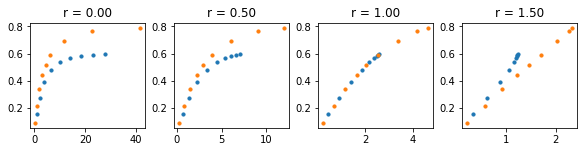

In [17]:
### for B
rb_test = [0,0.5,1,1.5]
dfb1 = dflist[0]
dfb2 = dflist[2]

fig,axes = plt.subplots(1,4,figsize=(8,2),constrained_layout=True)
ax = axes.flatten()


# We need time increments and concentration averages on intervals
for ii,rb in enumerate(rb_test):
    ax[ii].set_title("r = %.2f" % rb)
    # differences
    dt1 = dfb1["time"].diff().dropna()
    dt2 = dfb2["time"].diff().dropna()
    
    # averages
    avg1 = dfb1.rolling(window=2).mean().dropna()
    avg2 = dfb2.rolling(window=2).mean().dropna()
    x1 = dt1*(avg1["B"])**rb
    x2 = dt2*(avg2["B"])**rb
    # and the term is the cumulative sum
    ax[ii].scatter(x1.cumsum(),dfb1["P"].iloc[1:],s=10)
    ax[ii].scatter(x2.cumsum(),dfb2["P"].iloc[1:],s=10)




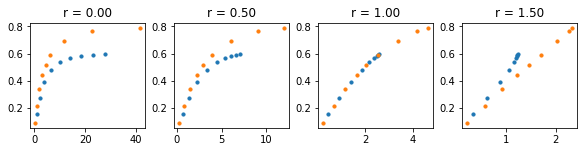

In [18]:
### for cat
rc_test = [0,0.5,1,1.5]
dfc1 = dflist[0]
dfc2 = dflist[2]

fig,axes = plt.subplots(1,4,figsize=(8,2),constrained_layout=True)
ax = axes.flatten()


# We need time increments and concentration averages on intervals
for ii,rc in enumerate(rc_test):
    ax[ii].set_title("r = %.2f" % rc)
    # differences
    dt1 = dfc1["time"].diff().dropna()
    dt2 = dfc2["time"].diff().dropna()
    
    # averages
    avg1 = dfc1.rolling(window=2).mean().dropna()
    avg2 = dfc2.rolling(window=2).mean().dropna()
    x1 = dt1*(avg1["B"])**rc
    x2 = dt2*(avg2["B"])**rc
    # and the term is the cumulative sum
    ax[ii].scatter(x1.cumsum(),dfc1["P"].iloc[1:],s=10)
    ax[ii].scatter(x2.cumsum(),dfc2["P"].iloc[1:],s=10)



In [19]:
### Best practice: encapsulate in a function
def apply_vtna(expo_list,df_list,target,plotted_spc):
    Nexpo = len(expo_list)
    fig,axes = plt.subplots(1,Nexpo,figsize=(Nexpo*2,2))
    ax = axes.flatten()


    # We need time increments and concentration averages on intervals
    for ii,rr in enumerate(expo_list):
        ax[ii].set_title("r = %.2f" % rr)
        ## Time differences and averages
        dt_list = []
        avg_list = []
        x_list = []
        for df in df_list:
            dt = df["time"].diff().dropna()
            avg = df.rolling(window=2).mean().dropna()
            x = dt*(avg[target])**rr
            xsum = x.cumsum()
            x_list.append(xsum)
            # plot
            ax[ii].scatter(xsum,df["P"].iloc[1:],s=10)
    plt.tight_layout()
    return fig,ax,x_list

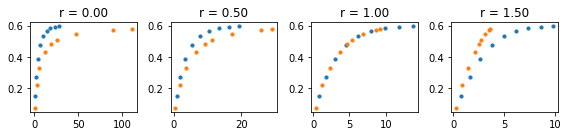

In [20]:
# Test the function for A
dfsA = [dflist[0],dflist[1]]
out = apply_vtna(ra_test,dfsA,"A","P")

In [166]:
### Use arrays instead of dataframes for a more DIY approach

ra = 1.0

arr1 = dflist[0].to_numpy()
arr2 = dflist[1].to_numpy()

dt1 = arr1[1:,0] - arr1[0:-1,0]
dt2 = arr2[1:,0] - arr2[0:-1,0]

avg1 = 0.5*(arr1[1:,1] + arr1[0:-1,1])
avg2 = 0.5*(arr2[1:,1] + arr2[0:-1,1])

term1 = dt1*avg1**ra
term2 = dt2*avg2**ra

Z1 = np.zeros_like(term1)
Z2 = np.zeros_like(term2)

for jj,item in enumerate(term1):
    Z1[jj] = term1[0:jj+1].sum()
    
for jj,item in enumerate(term2):
    Z2[jj] = term2[0:jj+1].sum()

Text(0, 0.5, '[P]/M')

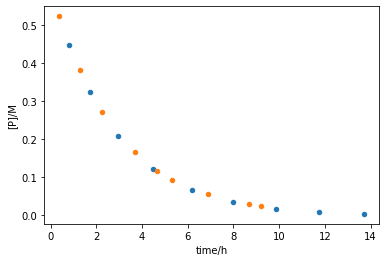

In [167]:
# Plot it
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(Z1,arr1[1:,2],s=20)
ax.scatter(Z2,arr2[1:,2],s=20)
ax.set_xlabel("time/h")
ax.set_ylabel("[P]/M")

Other tests for catalyst-based method, for reference

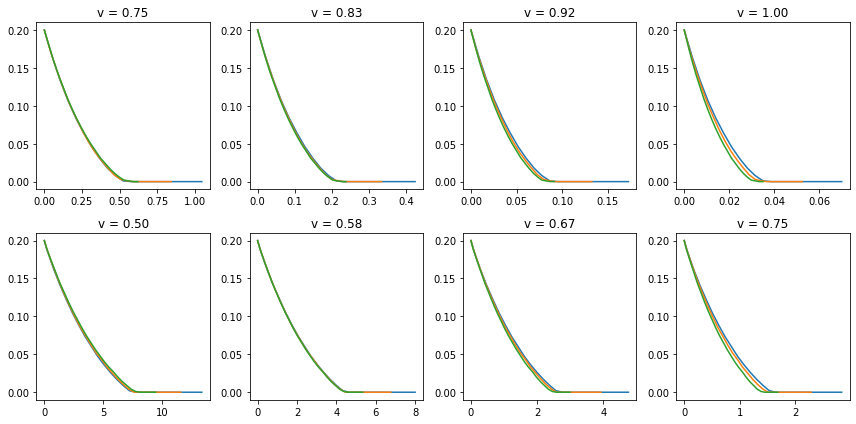

In [21]:
### Test 2
data_m21 = pd.read_csv("datasets/m3_heckcoupling_set1.dat",sep=" ")
data_m22 = pd.read_csv("datasets/m3_heckcoupling_set2.dat",sep=" ")

# two sets of conc. values
exp_valsA = np.linspace(0.75,1,4)
exp_valsB = np.linspace(0.5,0.75,4)

c_valsA = [float(item) for item in data_m21.columns[1:]]
c_valsB = [float(item) for item in data_m22.columns[1:]]

fig,axes = plt.subplots(2,4,figsize=(12,6))
ax = axes.flatten()
for ii,v in enumerate(exp_valsA):
    time = data_m21["time"]
    ax[ii].set_title("v = %.2f" % v)
    for jj,cat in enumerate(c_valsA):
        x = time*(cat)**v
        ax[ii].plot(x,data_m21.iloc[:,jj+1])
        
for ii,v in enumerate(exp_valsB):       
    time = data_m22["time"]
    ax[ii+4].set_title("v = %.2f" % v) 
    for jj,cat in enumerate(c_valsB):
        x = time*(cat)**v
        ax[ii+4].plot(x,data_m22.iloc[:,jj+1])

plt.tight_layout()
